In [45]:
import pandas as pd
import string
import re
from pickle import dump
from pickle import load
from unicodedata import normalize
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.regularizers import L1L2
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers

from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from nltk.translate.bleu_score import corpus_bleu

In [61]:
# reading the data
df = pd.read_csv('fra.txt',sep='\t', header = None, encoding = 'utf-8')
df.drop(2, axis = 1, inplace=True)
df.columns=['en', 'fr']
print(df.info())
df.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170651 entries, 0 to 170650
Data columns (total 2 columns):
en    170651 non-null object
fr    170651 non-null object
dtypes: object(2)
memory usage: 2.6+ MB
None


,en,fr
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !
5,Who?,Qui ?
6,Wow!,Ça alors !
7,Fire!,Au feu !
8,Help!,À l'aide !
9,Jump.,Saute.


In [62]:
# cleaning the data
def clean_data(phrase):
    punct_to_remove = str.maketrans('', '', string.punctuation)
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    
    # removes non-ascii chars, lowercases the words, removes punctuation, removes non-printable chars, 
    # removes tokens that contain numbers
    phrase = normalize('NFD', phrase).encode('ascii', 'ignore')
    phrase = phrase.decode('UTF-8')
    phrase = phrase.split()
    phrase = [w.lower() for w in phrase]
    phrase = [w.translate(punct_to_remove) for w in phrase]
    phrase = [re_print.sub('', w) for w in phrase]
    phrase = [w for w in phrase if w.isalpha()]
    
    clean_phrase = ' '.join(phrase)
    return clean_phrase
    
def clean_df(df):
    df['en'] = df['en'].apply(clean_data)
    df['fr'] = df['fr'].apply(clean_data)
    return df

In [63]:
df = clean_df(df)
df.to_csv('clean_data_en_fr.csv', index = None)
df.head()

,en,fr
0,go,va
1,hi,salut
2,hi,salut
3,run,cours
4,run,courez


In [133]:
# reading in the clean data and splitting into train and test
df = pd.read_csv('clean_data_en_fr.csv')


170651

In [64]:
df = df[0:20000]
df = shuffle(df)
train_df = df[0:18000]
test_df = df[18000:20000]
len(test_df)


2000

In [65]:
# encode sequences with integers and pad with zeros
def encode_phrases(tknzr, max_length, phrases):
    seq = tknzr.texts_to_sequences(phrases)
    seq = pad_sequences(seq, maxlen=max_length, padding='post')
    return seq

# one hot encoding of the target translation
def onehot_output(seqs, vocab_size):
    seqs_onehot = list()
    for seq in seqs:
        
        # one hot encodes the words in a phrase
        seq_onehot = to_categorical(seq, num_classes=vocab_size)
        seqs_onehot.append(seq_onehot)
        
    # CHECK IF THESE 2 ARE NECESSARY
    y = array(seqs_onehot)
    y = y.reshape(seqs.shape[0], seqs.shape[1], vocab_size)
    return y


# tokenizers
en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(df['en'])

fr_tokenizer = Tokenizer()
fr_tokenizer.fit_on_texts(df['fr'])

# max length
en_max_length = max([len(phrase) for phrase in df['en'].str.split()])
fr_max_length = max([len(phrase) for phrase in df['fr'].str.split()])

#word_index
word_index=fr_tokenizer.word_index

# vocabulary size
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print('English vocab size: ' + str(en_vocab_size))
print('English max phrase length: ' + str(en_max_length))
print('French vocab size: ' + str(fr_vocab_size))
print('French max phrase length: ' + str(fr_max_length))



English vocab size: 3478
English max phrase length: 5
French vocab size: 6931
French max phrase length: 12


## Word2Vec Model

In [3]:
import os
import gensim
import warnings


In [139]:
with open("data.txt",encoding = 'utf-8') as file:
    lines = [clean_data(line.rstrip('\n')) for line in file]
    

['inc', 'aurant la therapie et au niveau sexuel']


In [140]:
def convert(lst): 
    return ([item for item in lst.split(" ")]) 
      
# Driver code 
all_sentences=[convert(phrase) for phrase in lines]


[['inc'],
 ['aurant', 'la', 'therapie', 'et', 'au', 'niveau', 'sexuel'],
 ['pas', 'encore']]

In [141]:
import gensim

model_w2v = gensim.models.Word2Vec(sentences=all_sentences, size=300, sg=1, hs=1)
if not os.path.exists('./WE_models'):
    os.mkdir('./WE_models')
model_w2v.save('WE_models/w2v_sg_300D')

In [35]:
#Load Word2VecModel
model_w2v = gensim.models.Word2Vec.load('WE_models/w2v_sg_300D')


In [24]:
words = list(model_w2v.wv.vocab)
pretrained_weights=model_w2v.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape
vocab_size, emdedding_size

['la', 'therapie', 'et', 'au', 'niveau', 'sexuel', 'pas', 'encore', 'il', 'veut']


In [25]:
#Load the model
model_w2v = gensim.models.Word2Vec.load('WE_models/w2v_sg_300D')
#See the most similar words to cours
model_w2v.wv.most_similar('cours')


[('turbulences', 0.4291991591453552),
 ('dintro', 0.42504751682281494),
 ('modifications', 0.41741570830345154),
 ('repetitions', 0.41544803977012634),
 ('visites', 0.41166946291923523),
 ('semestre', 0.4116436243057251),
 ('lindependance', 0.39758729934692383),
 ('retouches', 0.39716506004333496),
 ('phases', 0.3952268660068512),
 ('usines', 0.39489084482192993)]

In [66]:
#pretrained wordembeddings

def create_model(vocab_size_src, embedding_size, vocab_size_trg, seq_size_src, seq_size_trg, n_nodes):
    nn = Sequential()
    nn.add(Embedding(input_dim=vocab_size_src, output_dim=embedding_size,weights=[pretrained_weights],input_length=seq_size_src, mask_zero=True,trainable=False))
    #nn.add(LSTM(n_nodes,bias_regularizer=L1L2(l1=0.02, l2=0.02)))
    nn.add(LSTM(n_nodes))

    #nn.add(Dropout(0.2))
    nn.add(RepeatVector(seq_size_trg))
    nn.add(LSTM(n_nodes, return_sequences=True))

    #nn.add(LSTM(n_nodes, return_sequences=True,bias_regularizer=L1L2(l1=0.02, l2=0.02)))
    #nn.add(Dropout(0.2))
    nn.add(TimeDistributed(Dense(vocab_size_trg, activation='softmax')))
    return nn

# prepare training data
train_src = encode_phrases(fr_tokenizer, fr_max_length, train_df['fr'])
train_trg = encode_phrases(en_tokenizer, en_max_length, train_df['en'])
train_trg = onehot_output(train_trg, en_vocab_size)

# prepare validation data
test_src = encode_phrases(fr_tokenizer, fr_max_length, test_df['fr'])
test_trg = encode_phrases(en_tokenizer, en_max_length, test_df['en'])
test_trg = onehot_output(test_trg, en_vocab_size)

# create model
model = create_model(vocab_size, emdedding_size , en_vocab_size, fr_max_length, en_max_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')#, metrics = ['accuracy'])

# summary of the model
print(model.summary())

saved_file_name = 'model30.h5'
checkpoint = ModelCheckpoint(saved_file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history=model.fit(train_src, train_trg, epochs=30, batch_size=64, validation_data=(test_src, test_trg), callbacks=[checkpoint], verbose=2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 12, 300)           2750700   
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               570368    
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 5, 256)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 5, 3478)           893846    
Total params: 4,740,226
Trainable params: 1,989,526
Non-trainable params: 2,750,700
_________________________________________________________________
None
Train on 18000 samples, validate on 2000 samples
Epoch 1/30
 - 49s - loss: 4.2893 - val_loss: 3.8

In [58]:
# map an integer to a word
def get_words(indexes, trg_tokenizer):
    translation = []
    for index in indexes:
        for w, i in trg_tokenizer.word_index.items():
            if i == index:
                translation.append(w)
                break
    return translation

# generate target given source sequence
def translate_phrase(model, trg_tokenizer, src_phrase):
    translation_probs = model.predict(src_phrase, verbose=0)[0]
    indexes = []
    for v in translation_probs:
        indexes.append(argmax(v))
    translation = get_words(indexes, trg_tokenizer)
    return ' '.join(translation)



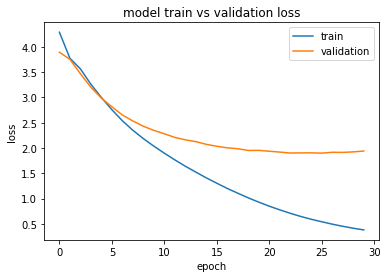

In [67]:
import matplotlib.pyplot as pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [68]:
# french to english

def evaluate_model(model, trg_tokenizer, src_phrases, original_data):
    original_translations = []
    predicted_translations = []
    for i, phrase in enumerate(src_phrases):
        # translate encoded source text
        phrase = phrase.reshape((1, phrase.shape[0])) # need to check if necessary
        translation = translate_phrase(model, trg_tokenizer, phrase)
        original_trg, original_src = original_data.iloc[i]
        # can remove the printing part here
        if i < 5:
            print('source = {}, target = {}, predicted = {}'.format(original_src, original_trg, translation))
        original_translations.append([original_trg.split()])
        predicted_translations.append(translation.split())
    # BLEU score evaluation
    print('BLEU-1: {0:.5f}'.format(corpus_bleu(original_translations, predicted_translations, weights=(1.0, 0, 0, 0))))
    print('BLEU-2: {0:.5f}'.format(corpus_bleu(original_translations, predicted_translations, weights=(0.5, 0.5, 0, 0))))
    print('BLEU-3: {0:.5f}'.format(corpus_bleu(original_translations, predicted_translations, weights=(0.3, 0.3, 0.3, 0))))
    print('BLEU-4: {0:.5f}'.format(corpus_bleu(original_translations, predicted_translations, weights=(0.25, 0.25, 0.25, 0.25))))


# load model
model = load_model('model30.h5')

# evaluation of training results
print('train')
evaluate_model(model, en_tokenizer, train_src, train_df)

# evaluation of test results
print('test')
evaluate_model(model, en_tokenizer, test_src, test_df)

train
source = attache tes lacets, target = tie your shoes, predicted = tie your shoes
source = je paie mes propres dettes, target = i pay my own way, predicted = i pay my own
source = je suis tres serieuse, target = im quite serious, predicted = im very fat
source = les mecs sont stupides, target = guys are stupid, predicted = guys are stupid
source = il lui faut trouver du travail, target = he must find work, predicted = he must find work
BLEU-1: 0.84575
BLEU-2: 0.79374
BLEU-3: 0.73963
BLEU-4: 0.53475
test
source = jai besoin de volontaires, target = i need volunteers, predicted = i need to
source = tiens ta langue, target = bite your tongue, predicted = drink your
source = estu mannequin, target = are you a model, predicted = are you relaxed
source = tu ne peux pas sortir, target = you cant go out, predicted = you cant go
source = depechezvous sil vous plait, target = please hurry, predicted = please call me
BLEU-1: 0.55074
BLEU-2: 0.42896
BLEU-3: 0.36431
BLEU-4: 0.20585
